# Using Reinforcement Learning to play the Freeway game

**In this project we propose to apply Reinforcemente Learning control methods to learn how to play the Freeway Game.**  




In [ ]:
# ---------- Install the dependencies ----------

#!pip install gym
#!pip install gym[atari]

In [ ]:
# ---------- libraries ----------

import sys
sys.path.append('../')  # Enable importing from `src` folder

%matplotlib inline
from collections import defaultdict
from typing import List

import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

import gym

import src.agents as agents
import src.episode as episode
import src.environment as environment
import src.aux_plots as aux_plots

def print_result(i, scores, total_reward, score):
    if i % 10 == 0:
        print(f"Run [{i:4}] - Total reward: {total_reward:7.2f} Mean scores: {sum(scores) / len(scores):.2f} Means Scores[:-10]: {sum(scores[-10:]) / len(scores[-10:]):5.2f} Score: {score:2} ")

In [ ]:
# ---------- RAM mask for the selected features ----------

RAM_mask = [
      14  # The chicken Y-position value
    , 16  # Indicates if there was a collision
    , 108, 109, 110, 111, 112, 113, 114, 115, 116, 117  # Indicate the cars X-coordinates in each lane.
]

In [ ]:
# ---------- Restricting the chicken's field of view ----------

def reduce_state(ob):
    # Doesn't matter where we were hit
    ob[16] = 1 if ob[16] != 255 else 0

    # Reduce chicken y-position 
    ob[14] = ob[14] // 3

    for b in range(108, 118):
        # The chicken is in the x-posistion ~49
        if ob[b] < 19 or ob[b] > 79:
            # We don't need to represent cars far from the chicken
            ob[b] = 0
        else:
            # Reduce the cars x-positions sample space 
            ob[b] = ob[b] // 3

    return ob

In [ ]:
# ---------- Gym Freeway-ram-v4 environment ----------

env, initial_state = environment.get_env()

print("Action Space:", env.action_space)
print("Observation Space:", env.observation_space)

In [ ]:
# ---------- Reward possible conditions ----------

def reward_policy(reward, ob, action):
    if reward == 1:    # Cross all the lanes
        reward = reward_policy.REWARD_IF_CROSS
    
    elif ob[16] == 1:  # Collision!
        reward = reward_policy.REWARD_IF_COLISION
       
    elif action == 0:  # don't move (still)
        reward = reward_policy.REWARD_IF_STILL
        
    elif action == 1:  # Move ahead (up)
        reward = reward_policy.REWARD_IF_FW
    
    elif action == 2:  # Move back (down)
        reward = reward_policy.REWARD_IF_BW

    return reward

In [ ]:
# ---------- Running the baseline agent ----------

# baseline_scores = environment.run(agents.Baseline, render=False, n_runs=100, verbose=False)
#
# with open("baseline_scores.txt", "w") as f:
#     for item in baseline_scores:
#         f.write("%s\n" % item)

In [ ]:
with open("baseline_scores.txt") as f:
    baseline_scores = [int(x) for x in  f.read().splitlines()]

In [ ]:
# Mean score of the baseline agent
baseline_mean_score = sum(baseline_scores) / len(baseline_scores) 
print("Baseline mean score:", baseline_mean_score)

---

# 3. Q-Learning

## 3.1. influence of the number of actions

### 3.1.1) 2 actions (move up or stay):

In [68]:
# GAMMA = 0.99
# AVAILABLE_ACTIONS = 2
# N0 = 2.5

# reward_policy.REWARD_IF_CROSS = 500
# reward_policy.REWARD_IF_COLISION = -10
# reward_policy.REWARD_IF_STILL = -1
# reward_policy.REWARD_IF_FW = 0 

# n_runs = 7000

In [69]:
# env, initial_state = environment.get_env()
# agent = agents.QLearning(gamma=GAMMA, available_actions=AVAILABLE_ACTIONS, N0=N0)

# scores_2act = []
# total_rewards_2act = []

In [70]:
# %%time

# for i in range(n_runs):
#     #render = i % 100 == 0
#     render = 0

#     game_over = False
#     state = env.reset()
#     state = reduce_state(state)[RAM_mask].data.tobytes()  # Select useful bytes
#     action = agent.act(state)
   
#     score = 0
#     total_reward = 0

#     while not game_over:
#         if render:
#             time.sleep(0.015)
#             env.render()

#         old_state = state
#         ob, reward, game_over, _ = env.step(action)

#         ob = reduce_state(ob)
#         reward = reward_policy(reward, ob, action)

#         total_reward += reward

#         if reward == reward_policy.REWARD_IF_CROSS:
#             score += 1

#         state = ob[RAM_mask].data.tobytes()

#         agent.update_Q(old_state, state, action, reward)

#         action = agent.act(state)  # Next action

#     scores_2act.append(score)
#     total_rewards_2act.append(total_reward)
    
#     if i % 100 == 0:
#         print_result(i, scores_2act, total_reward, score)

Run [   0] - Total reward: 4467.00 Mean scores: 13.00 Means Scores[:-10]: 13.00 Score: 13 
Run [ 100] - Total reward: 8172.00 Mean scores: 16.25 Means Scores[:-10]: 18.20 Score: 19 
Run [ 200] - Total reward: 9783.00 Mean scores: 17.91 Means Scores[:-10]: 19.90 Score: 22 
Run [ 300] - Total reward: 8279.00 Mean scores: 18.91 Means Scores[:-10]: 21.00 Score: 19 
Run [ 400] - Total reward: 8795.00 Mean scores: 19.61 Means Scores[:-10]: 21.40 Score: 20 
Run [ 500] - Total reward: 10663.00 Mean scores: 20.24 Means Scores[:-10]: 23.10 Score: 23 
Run [ 600] - Total reward: 8897.00 Mean scores: 20.82 Means Scores[:-10]: 23.50 Score: 20 
Run [ 700] - Total reward: 11127.00 Mean scores: 21.34 Means Scores[:-10]: 25.30 Score: 24 
Run [ 800] - Total reward: 10570.00 Mean scores: 21.76 Means Scores[:-10]: 24.10 Score: 23 
Run [ 900] - Total reward: 11656.00 Mean scores: 22.15 Means Scores[:-10]: 25.40 Score: 25 
Run [1000] - Total reward: 11274.00 Mean scores: 22.51 Means Scores[:-10]: 25.20 Score

In [71]:
# with open("QL/QL_scores_2act.txt", "w") as f:
#    for item in scores_2act:
#        f.write("%s\n" % item)

# with open("QL/QL_total_rewards_2act.txt", "w") as f:
#    for item in total_rewards_2act:
#        f.write("%s\n" % item)

In [ ]:
with open("QL/QL_scores_2act.txt") as f:
   scores_2act = [int(x) for x in  f.read().splitlines()]

with open("QL/QL_total_rewards_2act.txt") as f:
   total_rewards_2act = [int(x) for x in  f.read().splitlines()]

### - 3 actions (move forward, stay or move backard):

In [82]:
GAMMA = 0.99
AVAILABLE_ACTIONS = 3
N0 = 2.5

reward_policy.REWARD_IF_CROSS = 500
reward_policy.REWARD_IF_COLISION = -10
reward_policy.REWARD_IF_STILL = -1
reward_policy.REWARD_IF_FW = 0 
reward_policy.REWARD_IF_BW = -9

n_runs = 4000

In [83]:
env, initial_state = environment.get_env()
agent = agents.QLearning(gamma=GAMMA, available_actions=AVAILABLE_ACTIONS, N0=N0)

scores_3act = []
total_rewards_3act = []

In [84]:
%%time

for i in range(n_runs):
    #render = i % 100 == 0
    render = 0

    game_over = False
    state = env.reset()
    state = reduce_state(state)[RAM_mask].data.tobytes()  # Select useful bytes
    action = agent.act(state)
   
    score = 0
    total_reward = 0

    while not game_over:
        if render:
            time.sleep(0.015)
            env.render()

        old_state = state
        ob, reward, game_over, _ = env.step(action)

        ob = reduce_state(ob)
        reward = reward_policy(reward, ob, action)

        total_reward += reward

        if reward == reward_policy.REWARD_IF_CROSS:
            score += 1

        state = ob[RAM_mask].data.tobytes()

        agent.update_Q(old_state, state, action, reward)

        action = agent.act(state)  # Next action

    scores_3act.append(score)
    total_rewards_3act.append(total_reward)
    
    if i % 100 == 0:
        print_result(i, scores_3act, total_reward, score)

Run [   0] - Total reward: -9072.00 Mean scores: 0.00 Means Scores[:-10]:  0.00 Score:  0 
Run [ 100] - Total reward: -1738.00 Mean scores: 2.58 Means Scores[:-10]:  7.80 Score:  8 
Run [ 200] - Total reward:  -62.00 Mean scores: 6.30 Means Scores[:-10]: 10.60 Score: 10 
Run [ 300] - Total reward: 5043.00 Mean scores: 8.43 Means Scores[:-10]: 15.10 Score: 17 
Run [ 400] - Total reward: 4174.00 Mean scores: 10.45 Means Scores[:-10]: 17.50 Score: 15 
Run [ 500] - Total reward: 7162.00 Mean scores: 12.17 Means Scores[:-10]: 18.90 Score: 20 
Run [ 600] - Total reward: 7395.00 Mean scores: 13.40 Means Scores[:-10]: 19.00 Score: 20 
Run [ 700] - Total reward: 7440.00 Mean scores: 14.38 Means Scores[:-10]: 20.40 Score: 20 
Run [ 800] - Total reward: 8139.00 Mean scores: 15.19 Means Scores[:-10]: 21.40 Score: 21 
Run [ 900] - Total reward: 9789.00 Mean scores: 15.91 Means Scores[:-10]: 22.00 Score: 23 
Run [1000] - Total reward: 9975.00 Mean scores: 16.52 Means Scores[:-10]: 22.20 Score: 24 
R

In [ ]:
with open("QL/QL_scores_3act.txt", "w") as f:
   for item in scores_3act:
       f.write("%s\n" % item)

with open("QL/QL_total_rewards_3act.txt", "w") as f:
   for item in total_rewards_3act:
       f.write("%s\n" % item)

In [ ]:
# with open("QL/QL_scores_3act.txt") as f:
#    scores_3act = [int(x) for x in  f.read().splitlines()]

# with open("QL/QL_total_rewards_3act.txt") as f:
#    total_rewards_3act = [int(x) for x in  f.read().splitlines()]

### - Results with different number of actions:

In [ ]:
import importlib
importlib.reload(aux_plots)

<module 'src.aux_plots' from '/home/aline/Documents/GitHub/FreewayGame/aline.almeida/src/aux_plots.py'>

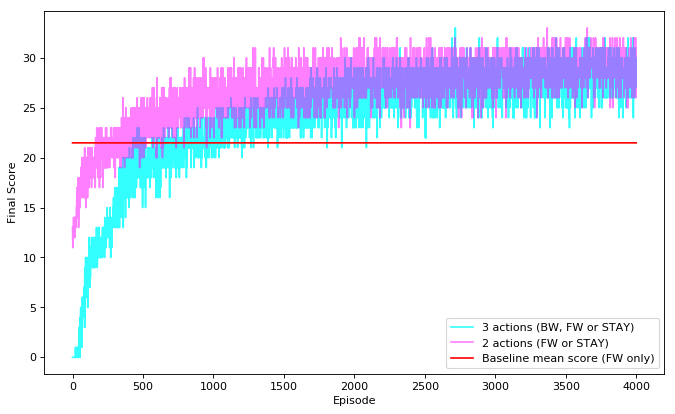

In [85]:
baseline = [baseline_mean_score for i in range(4000)]
aux_plots.plot_3scores(scores_3act[:4000], scores_2act[:4000], baseline[:4000], "3 actions (BW, FW or STAY)", "2 actions (FW or STAY)", "Baseline mean score (FW only)")

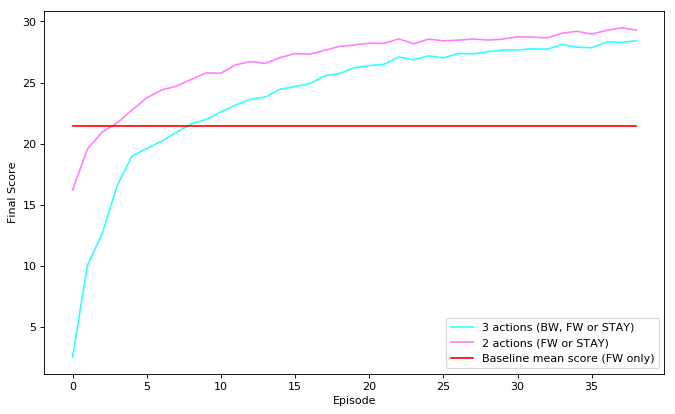

In [89]:
import statistics 

s1 = scores_3act[:4000]
s2 = scores_2act[:4000]
s3 = baseline[:4000]

blocks = 4000//100
s1_avg100 = []
for b in range(blocks-1):
    value = statistics.mean(s1[b*100:(b+1)*100])
    s1_avg100.append(value)

s2_avg100 = []
for b in range(blocks-1):
    value = statistics.mean(s2[b*100:(b+1)*100])
    s2_avg100.append(value)
    
s3_avg100 = []
for b in range(blocks-1):
    value = statistics.mean(s3[b*100:(b+1)*100])
    s3_avg100.append(value)
    
aux_plots.plot_3scores(s1_avg100, s2_avg100, s3_avg100, "3 actions (BW, FW or STAY)", "2 actions (FW or STAY)", "Baseline mean score (FW only)")

---

In [ ]:
import statistics 

s1 = total_scores_3act[:4000]
s2 = scores_2act[:4000]
s3 = baseline[:4000]

blocks = 4000//100
s1_avg100 = []
for b in range(blocks-1):
    value = statistics.mean(s1[b*100:(b+1)*100])
    s1_avg100.append(value)

s2_avg100 = []
for b in range(blocks-1):
    value = statistics.mean(s2[b*100:(b+1)*100])
    s2_avg100.append(value)
    
s3_avg100 = []
for b in range(blocks-1):
    value = statistics.mean(s3[b*100:(b+1)*100])
    s3_avg100.append(value)
    
aux_plots.plot_3scores(s1_avg100, s2_avg100, s3_avg100, "3 actions (BW, FW or STAY)", "2 actions (FW or STAY)", "Baseline mean score (FW only)")

## Changing hyper parameters: Reward values

### - Sparse reward: $+1$ if cross the street, $-1$ if collide

In [77]:
GAMMA = 0.99
AVAILABLE_ACTIONS = 2
N0 = 2.5

reward_policy.REWARD_IF_CROSS = 1
reward_policy.REWARD_IF_COLISION = -1
reward_policy.REWARD_IF_STILL = 0
reward_policy.REWARD_IF_FW = 0 

n_runs = 3000

In [78]:
env, initial_state = environment.get_env()
agent = agents.QLearning(gamma=GAMMA, available_actions=AVAILABLE_ACTIONS, N0=N0)

scores_2act_sparseR = []
total_rewards_2act_sparseR = []

In [79]:
%%time

for i in range(n_runs):
    #render = i % 100 == 0
    render = 0

    game_over = False
    state = env.reset()
    state = reduce_state(state)[RAM_mask].data.tobytes()  # Select useful bytes
    action = agent.act(state)
   
    score = 0
    total_reward = 0

    while not game_over:
        if render:
            time.sleep(0.015)
            env.render()

        old_state = state
        ob, reward, game_over, _ = env.step(action)

        ob = reduce_state(ob)
        reward = reward_policy(reward, ob, action)

        total_reward += reward

        if reward == reward_policy.REWARD_IF_CROSS:
            score += 1

        state = ob[RAM_mask].data.tobytes()

        agent.update_Q(old_state, state, action, reward)

        action = agent.act(state)  # Next action

    scores_2act_sparseR.append(score)
    total_rewards_2act_sparseR.append(total_reward)
    
    if i % 100 == 0:
        print_result(i, scores_2act_sparseR, total_reward, score)

Run [   0] - Total reward:  -65.00 Mean scores: 10.00 Means Scores[:-10]: 10.00 Score: 10 


KeyboardInterrupt: 

In [80]:
with open("QL/QL_scores_2act_sparseR.txt", "w") as f:
   for item in scores_2act_sparseR:
       f.write("%s\n" % item)

with open("QL/QL_total_rewards_2act_sparseR.txt", "w") as f:
   for item in total_rewards_2act_sparseR:
       f.write("%s\n" % item)

In [ ]:
# with open("QL/QL_scores_2act_sparseR.txt") as f:
#    scores_2act_sparseR = [int(x) for x in  f.read().splitlines()]

# with open("QL/QL_total_rewards_2act_sparseR.txt") as f:
#    total_rewards_2act_sparseR = [int(x) for x in  f.read().splitlines()]

### - Results with sparse and dense rewards:

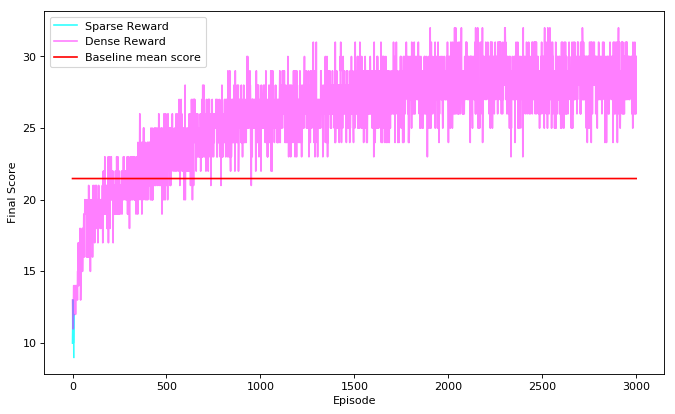

In [81]:
baseline = [baseline_mean_score for i in range(3000)]
aux_plots.plot_3scores(scores_2act_sparseR[:3000], scores_2act[:3000], baseline[:3000], "Sparse Reward", "Dense Reward", "Baseline mean score")

In [ ]:
s1 = scores_2act_sparseR[:3000]
s2 = scores_2act[:3000]
s3 = baseline[:3000]

blocks = 4000//100
s1_avg100 = []
for b in range(blocks-1):
    value = statistics.mean(s1[b*100:(b+1)*100])
    s1_avg100.append(value)

s2_avg100 = []
for b in range(blocks-1):
    value = statistics.mean(s2[b*100:(b+1)*100])\n",
    s2_avg100.append(value)"
    
s3_avg100 = []
for b in range(blocks-1):
    value = statistics.mean(s3[b*100:(b+1)*100])\n",
    s3_avg100.append(value)"
    
aux_plots.plot_3scores(s1_avg100, s2_avg100, s3_avg100, "3 actions (BW, FW or STAY)", "2 actions (FW or STAY)", "Baseline mean score (FW only)")

---

## Changing hyper parameters: Learning rate

### - $N0$ = 0.001

In [ ]:
GAMMA = 0.99
AVAILABLE_ACTIONS = 2
N0 =  0.001

reward_policy.REWARD_IF_CROSS = 500
reward_policy.REWARD_IF_COLISION = -10
reward_policy.REWARD_IF_STILL = -1
reward_policy.REWARD_IF_FW = 0 

n_runs = 7000

In [ ]:
env, initial_state = environment.get_env()
agent = agents.QLearning(gamma=GAMMA, available_actions=AVAILABLE_ACTIONS, N0=N0)

scores_2act_N0_0 = []
total_rewards_2act_N0_0 = []

In [ ]:
%%time

for i in range(n_runs):
    #render = i % 100 == 0
    render = 0

    game_over = False
    state = env.reset()
    state = reduce_state(state)[RAM_mask].data.tobytes()  # Select useful bytes
    action = agent.act(state)
   
    score = 0
    total_reward = 0

    while not game_over:
        if render:
            time.sleep(0.015)
            env.render()

        old_state = state
        ob, reward, game_over, _ = env.step(action)

        ob = reduce_state(ob)
        reward = reward_policy(reward, ob, action)

        total_reward += reward

        if reward == reward_policy.REWARD_IF_CROSS:
            score += 1

        state = ob[RAM_mask].data.tobytes()

        agent.update_Q(old_state, state, action, reward)

        action = agent.act(state)  # Next action

    scores_2act_N0_0.append(score)
    total_rewards_2act_N0_0.append(total_reward)
    
    if i % 100 == 0:
        print_result(i, scores_2act_N0_0, total_reward, score)

Run [   0] - Total reward: 4732.00 Mean scores: 13.00 Means Scores[:-10]: 13.00 Score: 13 
CPU times: user 1min 57s, sys: 60 ms, total: 1min 57s
Wall time: 1min 57s


In [ ]:
with open("QL/QL_scores_2act_N0_0.txt", "w") as f:
   for item in scores_2act_N0_0:
       f.write("%s\n" % item)

with open("QL/QL_total_rewards_2act_N0_0.txt", "w") as f:
   for item in total_rewards_2act_N0_0:
       f.write("%s\n" % item)

In [ ]:
# with open("QL/QL_scores_2act_N0_0.txt") as f:
#    scores_2act_N0_0 = [int(x) for x in  f.read().splitlines()]

# with open("QL/QL_total_rewards_2act_N0_0.txt") as f:
#    total_rewards_2act_N0_0 = [int(x) for x in  f.read().splitlines()]

### - $N0$ = 5

In [ ]:
GAMMA = 0.99
AVAILABLE_ACTIONS = 2
N0 =  5

reward_policy.REWARD_IF_CROSS = 500
reward_policy.REWARD_IF_COLISION = -10
reward_policy.REWARD_IF_STILL = -1
reward_policy.REWARD_IF_FW = 0 

n_runs = 7000

In [ ]:
env, initial_state = environment.get_env()
agent = agents.QLearning(gamma=GAMMA, available_actions=AVAILABLE_ACTIONS, N0=N0)

scores_2act_N0_5 = []
total_rewards_2act_N0_5 = []

In [ ]:
%%time

for i in range(n_runs):
    #render = i % 100 == 0
    render = 0

    game_over = False
    state = env.reset()
    state = reduce_state(state)[RAM_mask].data.tobytes()  # Select useful bytes
    action = agent.act(state)
   
    score = 0
    total_reward = 0

    while not game_over:
        if render:
            time.sleep(0.015)
            env.render()

        old_state = state
        ob, reward, game_over, _ = env.step(action)

        ob = reduce_state(ob)
        reward = reward_policy(reward, ob, action)

        total_reward += reward

        if reward == reward_policy.REWARD_IF_CROSS:
            score += 1

        state = ob[RAM_mask].data.tobytes()

        agent.update_Q(old_state, state, action, reward)

        action = agent.act(state)  # Next action

    scores_2act_N0_5.append(score)
    total_rewards_2act_N0_5.append(total_reward)
    
    if i % 100 == 0:
        print_result(i, scores_2act_N0_5, total_reward, score)

Run [   0] - Total reward: 4057.00 Mean scores: 12.00 Means Scores[:-10]: 12.00 Score: 12 
CPU times: user 2min 1s, sys: 72 ms, total: 2min 1s
Wall time: 2min 1s


In [ ]:
with open("QL/QL_scores_2act_N0_5.txt", "w") as f:
   for item in scores_2act_N0_5:
       f.write("%s\n" % item)

with open("QL/QL_total_rewards_2act_N0_5.txt", "w") as f:
   for item in total_rewards_2act_N0_5:
       f.write("%s\n" % item)

In [ ]:
# with open("QL/QL_scores_2act_N0_5.txt") as f:
#    scores_2act_N0_5 = [int(x) for x in  f.read().splitlines()]

# with open("QL/QL_total_rewards_2act_N0_5.txt") as f:
#    total_rewards_2act_N0_5 = [int(x) for x in  f.read().splitlines()]

### - Results with different $N0$ values:

In [ ]:
aux_plots.plot_3scores(scores_2act_N0_0d, scores_2act, scores_2act_N0_5, "N0=0.0", "N0=2.5", "N0=5.0")

In [ ]:
s1 = scores_2act_N0_0d
s2 = scores_2act
s3 = scores_2act_N0_5

blocks = 4000//100
s1_avg100 = []
for b in range(blocks-1):
    value = statistics.mean(s1[b*100:(b+1)*100])
    s1_avg100.append(value)

s2_avg100 = []
for b in range(blocks-1):
    value = statistics.mean(s2[b*100:(b+1)*100])\n",
    s2_avg100.append(value)"
    
s3_avg100 = []
for b in range(blocks-1):
    value = statistics.mean(s3[b*100:(b+1)*100])\n",
    s3_avg100.append(value)"
    
aux_plots.plot_3scores(s1_avg100, s2_avg100, s3_avg100, "3 actions (BW, FW or STAY)", "2 actions (FW or STAY)", "Baseline mean score (FW only)")

---

## Changing hyper parameters: Discount factor

### - $ɣ$ = 0.90

In [ ]:
GAMMA = 0.90
AVAILABLE_ACTIONS = 2
N0 =  2.5

reward_policy.REWARD_IF_CROSS = 500
reward_policy.REWARD_IF_COLISION = -10
reward_policy.REWARD_IF_STILL = -1
reward_policy.REWARD_IF_FW = 0 

n_runs = 3000

In [ ]:
env, initial_state = environment.get_env()
agent = agents.QLearning(gamma=GAMMA, available_actions=AVAILABLE_ACTIONS, N0=N0)

scores_2act_gamma_0p9 = []
total_rewards_2act_gamma_0p9 = []

In [ ]:
%%time

for i in range(n_runs):
    #render = i % 100 == 0
    render = 0

    game_over = False
    state = env.reset()
    state = reduce_state(state)[RAM_mask].data.tobytes()  # Select useful bytes
    action = agent.act(state)
   
    score = 0
    total_reward = 0

    while not game_over:
        if render:
            time.sleep(0.015)
            env.render()

        old_state = state
        ob, reward, game_over, _ = env.step(action)

        ob = reduce_state(ob)
        reward = reward_policy(reward, ob, action)

        total_reward += reward

        if reward == reward_policy.REWARD_IF_CROSS:
            score += 1

        state = ob[RAM_mask].data.tobytes()

        agent.update_Q(old_state, state, action, reward)

        action = agent.act(state)  # Next action

    scores_2act_gamma_0p9.append(score)
    total_rewards_2act_gamma_0p9.append(total_reward)
    
    if i % 100 == 0:
        print_result(i, scores_2act_gamma_0p9, total_reward, score)

Run [   0] - Total reward: 3505.00 Mean scores: 11.00 Means Scores[:-10]: 11.00 Score: 11 
CPU times: user 2min 7s, sys: 124 ms, total: 2min 7s
Wall time: 2min 7s


In [ ]:
with open("QL/QL_scores_2act_gamma_0p9.txt", "w") as f:
   for item in scores_2act_gamma_0p9:
       f.write("%s\n" % item)

with open("QL/QL_total_rewards_2act_gamma_0p9.txt", "w") as f:
   for item in total_rewards_2act_gamma_0p9:
       f.write("%s\n" % item)

In [ ]:
# with open("QL/QL_scores_2act_gamma_0p9.txt") as f:
#    scores_2act_gamma_0p9 = [int(x) for x in  f.read().splitlines()]

# with open("QL/QL_total_rewards_2act_gamma_0p9.txt") as f:
#    total_rewards_2act_gamma_0p9 = [int(x) for x in  f.read().splitlines()]

### - $ɣ$ = 0.75

In [ ]:
GAMMA = 0.75
AVAILABLE_ACTIONS = 2
N0 =  2.5

reward_policy.REWARD_IF_CROSS = 500
reward_policy.REWARD_IF_COLISION = -10
reward_policy.REWARD_IF_STILL = -1
reward_policy.REWARD_IF_FW = 0 

n_runs = 3000

In [ ]:
env, initial_state = environment.get_env()
agent = agents.QLearning(gamma=GAMMA, available_actions=AVAILABLE_ACTIONS, N0=N0)

scores_2act_gamma_0p75 = []
total_rewards_2act_gamma_0p75 = []

In [ ]:
%%time

for i in range(n_runs):
    #render = i % 100 == 0
    render = 0

    game_over = False
    state = env.reset()
    state = reduce_state(state)[RAM_mask].data.tobytes()  # Select useful bytes
    action = agent.act(state)
   
    score = 0
    total_reward = 0

    while not game_over:
        if render:
            time.sleep(0.015)
            env.render()

        old_state = state
        ob, reward, game_over, _ = env.step(action)

        ob = reduce_state(ob)
        reward = reward_policy(reward, ob, action)

        total_reward += reward

        if reward == reward_policy.REWARD_IF_CROSS:
            score += 1

        state = ob[RAM_mask].data.tobytes()

        agent.update_Q(old_state, state, action, reward)

        action = agent.act(state)  # Next action

    scores_2act_gamma_0p75.append(score)
    total_rewards_2act_gamma_0p75.append(total_reward)
    
    if i % 100 == 0:
        print_result(i, scores_2act_gamma_0p75, total_reward, score)

Run [   0] - Total reward: 4733.00 Mean scores: 13.00 Means Scores[:-10]: 13.00 Score: 13 
CPU times: user 2min 4s, sys: 104 ms, total: 2min 4s
Wall time: 2min 4s


In [ ]:
with open("QL/QL_scores_2act_gamma_0p75.txt", "w") as f:
   for item in scores_2act_gamma_0p75:
       f.write("%s\n" % item)

with open("QL/QL_total_rewards_2act_gamma_0p75.txt", "w") as f:
   for item in total_rewards_2act_gamma_0p75:
       f.write("%s\n" % item)

In [ ]:
# with open("QL/QL_scores_2act_gamma_0p75.txt") as f:
#    scores_2act_gamma_0p75 = [int(x) for x in  f.read().splitlines()]

# with open("QL/QL_total_rewards_2act_gamma_0p75.txt") as f:
#    total_rewards_2act_gamma_0p75 = [int(x) for x in  f.read().splitlines()]

### - Results with different $ɣ$ values:

In [ ]:
aux_plots.plot_3scores(scores_2act_gamma_0p9[:3000], scores_2act[:3000], scores_2act_gamma_0p75[:3000], "gamma=0.90", "gamma=0.99", "gamma=0.75")

In [ ]:
s1 = scores_2act_gamma_0p9[:3000]
s2 = scores_2act[:3000]
s3 = scores_2act_gamma_0p75[:3000]

blocks = 4000//100
s1_avg100 = []
for b in range(blocks-1):
    value = statistics.mean(s1[b*100:(b+1)*100])
    s1_avg100.append(value)

s2_avg100 = []
for b in range(blocks-1):
    value = statistics.mean(s2[b*100:(b+1)*100])\n",
    s2_avg100.append(value)"
    
s3_avg100 = []
for b in range(blocks-1):
    value = statistics.mean(s3[b*100:(b+1)*100])\n",
    s3_avg100.append(value)"
    
aux_plots.plot_3scores(s1_avg100, s2_avg100, s3_avg100, "3 actions (BW, FW or STAY)", "2 actions (FW or STAY)", "Baseline mean score (FW only)")

---

# Monte Carlo Control

## Changing hyper parameters: number of actions

### - 2 actions (move forward or stay):

In [49]:
GAMMA = 0.99
AVAILABLE_ACTIONS = 2
N0 = 2.5

reward_policy.REWARD_IF_CROSS = 500
reward_policy.REWARD_IF_COLISION = -10
reward_policy.REWARD_IF_STILL = -1
reward_policy.REWARD_IF_FW = 0 

n_runs = 7000

In [50]:
env, initial_state = environment.get_env()
agent = agents.MonteCarloControl(gamma=GAMMA, available_actions=AVAILABLE_ACTIONS, N0=N0)

def MonteCarloES(RAM_mask: List[int], render: bool=False):
    epi = episode.generate_episode(env, reduce_state=reduce_state, reward_policy=reward_policy, agent=agent, RAM_mask=RAM_mask, render=render)
    return agent.update_policy(epi)

scores_2act = []
total_rewards_2act = []

In [51]:
%%time
MonteCarloES(RAM_mask=RAM_mask, render=False)

CPU times: user 3.74 s, sys: 4 ms, total: 3.75 s
Wall time: 3.74 s


(13, 4551)

In [52]:
%%time

for i in range(n_runs):
    #render = i % 100 == 0
    render = 0
    
    score, total_reward = MonteCarloES(RAM_mask=RAM_mask, render=render)

    scores_2act.append(score)
    total_rewards_2act.append(total_reward)

    if i % 100 == 0:
        print_result(i, scores_2act, total_reward, score)

Run [   0] - Total reward: 5797.00 Mean scores: 15.00 Means Scores[:-10]: 15.00 Score: 15 
CPU times: user 2min 6s, sys: 76 ms, total: 2min 6s
Wall time: 2min 6s


In [53]:
with open("MC/MC_scores_2act.txt", "w") as f:
   for item in scores_2act:
       f.write("%s\n" % item)

with open("MC/MC_total_rewards_2act.txt", "w") as f:
   for item in total_rewards_2act:
       f.write("%s\n" % item)

In [ ]:
# with open("MC/MC_scores_2act.txt") as f:
#    scores_2act = [int(x) for x in  f.read().splitlines()]

# with open("MC/MC_total_rewards_2act.txt") as f:
#    total_rewards_2act = [int(x) for x in  f.read().splitlines()]

### - 3 actions (move forward, stay or move backard):

In [40]:
GAMMA = 0.99
AVAILABLE_ACTIONS = 3
N0 = 2.5

reward_policy.REWARD_IF_CROSS = 500
reward_policy.REWARD_IF_COLISION = -10
reward_policy.REWARD_IF_STILL = -1
reward_policy.REWARD_IF_FW = 0 
reward_policy.REWARD_IF_BW = -9

n_runs = 3000

In [45]:
env, initial_state = environment.get_env()
agent = agents.MonteCarloControl(gamma=GAMMA, available_actions=AVAILABLE_ACTIONS, N0=N0)

def MonteCarloES(RAM_mask: List[int], render: bool=False):
    epi = episode.generate_episode(env, reduce_state=reduce_state, reward_policy=reward_policy, agent=agent, RAM_mask=RAM_mask, render=render)
    return agent.update_policy(epi)

scores_3act = []
total_rewards_3act = []

In [46]:
%%time

for i in range(n_runs):
    #render = i % 100 == 0
    render = 0
    
    score, total_reward = MonteCarloES(RAM_mask=RAM_mask, render=render)

    scores_3act.append(score)
    total_rewards_3act.append(total_reward)

    if i % 100 == 0:
        print_result(i, scores_3act, total_reward, score)

Run [   0] - Total reward: -9550.00 Mean scores: 0.00 Means Scores[:-10]:  0.00 Score:  0 
CPU times: user 2min, sys: 27.9 ms, total: 2min
Wall time: 2min


In [43]:
with open("MC/MC_scores_3act.txt", "w") as f:
   for item in scores_3act:
       f.write("%s\n" % item)

with open("MC/MC_total_rewards_3act.txt", "w") as f:
   for item in total_rewards_3act:
       f.write("%s\n" % item)

In [ ]:
# with open("MC/MC_scores_3act.txt") as f:
#    scores_3act = [int(x) for x in  f.read().splitlines()]

# with open("MC/MC_total_rewards_3act.txt") as f:
#    total_rewards_3act = [int(x) for x in  f.read().splitlines()]

### - Results with different number of actions:

In [ ]:
baseline = [baseline_mean_score for i in range(3000)]
aux_plots.plot_3scores(scores_3act[:3000], scores_2act[:3000], baseline[:3000], "3 actions (BW, FW or STAY)", "2 actions (FW or STAY)", "Baseline mean score (FW only)")

---

## Changing hyper parameters: Reward values

### - Sparse reward: $+1$ if cross the street, $-1$ if collide

In [ ]:
GAMMA = 0.99
AVAILABLE_ACTIONS = 2
N0 = 2.5

reward_policy.REWARD_IF_CROSS = 1
reward_policy.REWARD_IF_COLISION = -1
reward_policy.REWARD_IF_STILL = 0
reward_policy.REWARD_IF_FW = 0 

n_runs = 3000

In [ ]:
env, initial_state = environment.get_env()
agent = agents.MonteCarloControl(gamma=GAMMA, available_actions=AVAILABLE_ACTIONS, N0=N0)

def MonteCarloES(RAM_mask: List[int], render: bool=False):
    epi = episode.generate_episode(env, reduce_state=reduce_state, reward_policy=reward_policy, agent=agent, RAM_mask=RAM_mask, render=render)
    return agent.update_policy(epi)


scores_2act_sparseR = []
total_rewards_2act_sparseR = []

In [ ]:
%%time

for i in range(n_runs):
    #render = i % 100 == 0
    render = 0
    
    score, total_reward = MonteCarloES(RAM_mask=RAM_mask, render=render)

    scores_2act_sparseR.append(score)
    total_rewards_2act_sparseR.append(total_reward)

    if i % 100 == 0:
        print_result(i, scores_2act_sparseR, total_reward, score)

In [ ]:
with open("MC/MC_scores_2act_sparseR.txt", "w") as f:
   for item in scores_2act_sparseR:
       f.write("%s\n" % item)

with open("MC/MC_total_rewards_2act_sparseR.txt", "w") as f:
   for item in total_rewards_2act_sparseR:
       f.write("%s\n" % item)

In [ ]:
# with open("MC/MC_scores_2act_sparseR.txt") as f:
#    scores_2act_sparseR = [int(x) for x in  f.read().splitlines()]

# with open("MC/MC_total_rewards_2act_sparseR.txt") as f:
#    total_rewards_2act_sparseR = [int(x) for x in  f.read().splitlines()]

### - Results with sparse and dense rewards:

In [ ]:
baseline = [baseline_mean_score for i in range(3000)]
aux_plots.plot_3scores(scores_2act_sparseR[:3000], scores_2act[:3000], baseline[:3000], "Sparse Reward", "Dense Reward", "Baseline mean score")

---

## Changing hyper parameters: Learning rate

### - $N0$ = 0.001

In [ ]:
GAMMA = 0.99
AVAILABLE_ACTIONS = 2
N0 =  0.001

reward_policy.REWARD_IF_CROSS = 500
reward_policy.REWARD_IF_COLISION = -10
reward_policy.REWARD_IF_STILL = -1
reward_policy.REWARD_IF_FW = 0 

n_runs = 7000

In [ ]:
env, initial_state = environment.get_env()
agent = agents.MonteCarloControl(gamma=GAMMA, available_actions=AVAILABLE_ACTIONS, N0=N0)

def MonteCarloES(RAM_mask: List[int], render: bool=False):
    epi = episode.generate_episode(env, reduce_state=reduce_state, reward_policy=reward_policy, agent=agent, RAM_mask=RAM_mask, render=render)
    return agent.update_policy(epi)

scores_2act_N0_0 = []
total_rewards_2act_N0_0 = []

In [ ]:
%%time

for i in range(n_runs):
    #render = i % 100 == 0
    render = 0
    
    score, total_reward = MonteCarloES(RAM_mask=RAM_mask, render=render)

    scores_2act_N0_0.append(score)
    total_rewards_2act_N0_0.append(total_reward)

    if i % 100 == 0:
        print_result(i, scores_2act_N0_0, total_reward, score)

In [ ]:
with open("MC/MC_scores_2act_N0_0.txt", "w") as f:
   for item in scores_2act_N0_0:
       f.write("%s\n" % item)

with open("MC/MC_total_rewards_2act_N0_0.txt", "w") as f:
   for item in total_rewards_2act_N0_0:
       f.write("%s\n" % item)

In [ ]:
# with open("MC/MC_scores_2act_N0_0.txt") as f:
#    scores_2act_N0_0 = [int(x) for x in  f.read().splitlines()]

# with open("MC/MC_total_rewards_2act_N0_0.txt") as f:
#    total_rewards_2act_N0_0 = [int(x) for x in  f.read().splitlines()]

### - $N0$ = 5

In [ ]:
GAMMA = 0.99
AVAILABLE_ACTIONS = 2
N0 =  5

reward_policy.REWARD_IF_CROSS = 500
reward_policy.REWARD_IF_COLISION = -10
reward_policy.REWARD_IF_STILL = -1
reward_policy.REWARD_IF_FW = 0 

n_runs = 7000

In [ ]:
env, initial_state = environment.get_env()
agent = agents.MonteCarloControl(gamma=GAMMA, available_actions=AVAILABLE_ACTIONS, N0=N0)

def MonteCarloES(RAM_mask: List[int], render: bool=False):
    epi = episode.generate_episode(env, reduce_state=reduce_state, reward_policy=reward_policy, agent=agent, RAM_mask=RAM_mask, render=render)
    return agent.update_policy(epi)

scores_2act_N0_5 = []
total_rewards_2act_N0_5 = []

In [ ]:
%%time

for i in range(n_runs):
    #render = i % 100 == 0
    render = 0
    
    score, total_reward = MonteCarloES(RAM_mask=RAM_mask, render=render)

    scores_2act_N0_5.append(score)
    total_rewards_2act_N0_5.append(total_reward)

    if i % 100 == 0:
        print_result(i, scores_2act_N0_5, total_reward, score)

In [ ]:
with open("MC/MC_scores_2act_N0_5.txt", "w") as f:
   for item in scores_2act_N0_5:
       f.write("%s\n" % item)

with open("MC/MC_total_rewards_2act_N0_5.txt", "w") as f:
   for item in total_rewards_2act_N0_5:
       f.write("%s\n" % item)

In [ ]:
# with open("MC/MC_scores_2act_N0_5.txt") as f:
#    scores_2act_N0_5 = [int(x) for x in  f.read().splitlines()]

# with open("MC/MC_total_rewards_2act_N0_5.txt") as f:
#    total_rewards_2act_N0_5 = [int(x) for x in  f.read().splitlines()]

### - Results with different $N0$ values:

In [ ]:
aux_plots.plot_3scores(scores_2act_N0_0, scores_2act, scores_2act_N0_5, "N0=0.0", "N0=2.5", "N0=5.0")

---

## Changing hyper parameters: Discount factor

### - $ɣ$ = 0.90

In [ ]:
GAMMA = 0.90
AVAILABLE_ACTIONS = 2
N0 =  2.5

reward_policy.REWARD_IF_CROSS = 500
reward_policy.REWARD_IF_COLISION = -10
reward_policy.REWARD_IF_STILL = -1
reward_policy.REWARD_IF_FW = 0 

n_runs = 3000

In [ ]:
env, initial_state = environment.get_env()
agent = agents.MonteCarloControl(gamma=GAMMA, available_actions=AVAILABLE_ACTIONS, N0=N0)

def MonteCarloES(RAM_mask: List[int], render: bool=False):
    epi = episode.generate_episode(env, reduce_state=reduce_state, reward_policy=reward_policy, agent=agent, RAM_mask=RAM_mask, render=render)
    return agent.update_policy(epi)

scores_2act_gamma_0p9 = []
total_rewards_2act_gamma_0p9 = []

In [ ]:
%%time

for i in range(n_runs):
    #render = i % 100 == 0
    render = 0
    
    score, total_reward = MonteCarloES(RAM_mask=RAM_mask, render=render)

    scores_2act_gamma_0p9.append(score)
    total_rewards_2act_gamma_0p9.append(total_reward)

    if i % 100 == 0:
        print_result(i, scores_2act_gamma_0p9, total_reward, score)

In [ ]:
with open("MC/MC_scores_2act_gamma_0p9.txt", "w") as f:
   for item in scores_2act_gamma_0p9:
       f.write("%s\n" % item)

with open("MC/MC_total_rewards_2act_gamma_0p9.txt", "w") as f:
   for item in total_rewards_2act_gamma_0p9:
       f.write("%s\n" % item)

In [ ]:
# with open("MC/MC_scores_2act_gamma_0p9.txt") as f:
#    scores_2act_gamma_0p9 = [int(x) for x in  f.read().splitlines()]

# with open("MC/MC_total_rewards_2act_gamma_0p9.txt") as f:
#    total_rewards_2act_gamma_0p9 = [int(x) for x in  f.read().splitlines()]

### - $ɣ$ = 0.75

In [ ]:
GAMMA = 0.75
AVAILABLE_ACTIONS = 2
N0 =  2.5

reward_policy.REWARD_IF_CROSS = 500
reward_policy.REWARD_IF_COLISION = -10
reward_policy.REWARD_IF_STILL = -1
reward_policy.REWARD_IF_FW = 0 

n_runs = 3000

In [ ]:
env, initial_state = environment.get_env()
agent = agents.MonteCarloControl(gamma=GAMMA, available_actions=AVAILABLE_ACTIONS, N0=N0)

def MonteCarloES(RAM_mask: List[int], render: bool=False):
    epi = episode.generate_episode(env, reduce_state=reduce_state, reward_policy=reward_policy, agent=agent, RAM_mask=RAM_mask, render=render)
    return agent.update_policy(epi)

scores_2act_gamma_0p75 = []
total_rewards_2act_gamma_0p75 = []

In [ ]:
%%time

for i in range(n_runs):
    #render = i % 100 == 0
    render = 0
    
    score, total_reward = MonteCarloES(RAM_mask=RAM_mask, render=render)

    scores_2act_gamma_0p75.append(score)
    total_rewards_2act_gamma_0p75.append(total_reward)

    if i % 100 == 0:
        print_result(i, scores_2act_gamma_0p75, total_reward, score)

In [ ]:
with open("MC/MC_scores_2act_gamma_0p75.txt", "w") as f:
   for item in scores_2act_gamma_0p75:
       f.write("%s\n" % item)

with open("MC/MC_total_rewards_2act_gamma_0p75.txt", "w") as f:
   for item in total_rewards_2act_gamma_0p75:
       f.write("%s\n" % item)

In [ ]:
# with open("MC/MC_scores_2act_gamma_0p75.txt") as f:
#    scores_2act_gamma_0p75 = [int(x) for x in  f.read().splitlines()]

# with open("MC/MC_total_rewards_2act_gamma_0p75.txt") as f:
#    total_rewards_2act_gamma_0p75 = [int(x) for x in  f.read().splitlines()]

### - Results with different $ɣ$ values:

In [ ]:
aux_plots.plot_3scores(scores_2act_gamma_0p9[:3000], scores_2act[:3000], scores_2act_gamma_0p75[:3000], "gamma=0.90", "gamma=0.99", "gamma=0.75")